In [1]:
import sys
sys.path.append("../")


In [2]:
from visualDet3D.utils.utils import cfg_from_file, load_model
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import draw_3D_box
from visualDet3D.data.pipeline import build_augmentator

from easydict import EasyDict as edict
import torch
import numpy as np
import cv2
from copy import deepcopy
import json
from itertools import groupby

from matplotlib import pyplot as plt
from PIL import Image

In [3]:
anno_pth = '/home/ubuntu/data/nuScenes_small/annotations/{}.json'.format('val')
    
with open(anno_pth) as f:
    nusc = json.load(f)

In [4]:
nusc['categories'] = {cate['id']: cate['name'] for cate in nusc['categories']}


In [5]:
nusc['annotations'] = sorted(nusc['annotations'], key=lambda k: k['image_id'])
sample_data = [[k, list(v)]for k, v in groupby(nusc['annotations'], lambda k: k['image_id'])]
nusc['images'] = {img['id']: img for img in nusc['images']}

In [3]:
cfg = cfg_from_file(
    '/home/ubuntu/visualDet3D/visualDet3D/workspace/Mono3D_nuscenes_450x800/checkpoint/config_nuscene_noDCN.py'
)


detector = DETECTOR_DICT['GroundAwareYolo3D'](cfg.detector)
detector = detector.cuda()

detector = load_model(
    detector,
    '/home/ubuntu/visualDet3D/visualDet3D/workspace/Mono3D_nuscenes_450x800/checkpoint/res18_GroundAwareYolo3D_best.pth'
)

init ground awarehead
loaded /home/ubuntu/visualDet3D/visualDet3D/workspace/Mono3D_nuscenes_450x800/checkpoint/res18_GroundAwareYolo3D_best.pth, epoch 14


In [4]:
def collate_fn(batch):
    rgb_images = np.array([item["image"]
                           for item in batch])  # [batch, H, W, 3]
    rgb_images = rgb_images.transpose([0, 3, 1, 2])

    calib = [item["calib"] for item in batch]
    return torch.from_numpy(rgb_images).float(), calib 


def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [5]:

def view_points(points: np.ndarray, view: np.ndarray, normalize: bool=True) -> np.ndarray:
    assert view.shape[0] <= 4
    assert view.shape[1] <= 4
    assert points.shape[0] == 3

    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view

    nbr_points = points.shape[1]

    # Do operation in homogenous coordinates.
    points = np.concatenate((points, np.ones((1, nbr_points))))
    points = np.dot(viewpad, points)
    points = points[:3, :]

    if normalize:
        points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)

    return points

def draw_box_3d(image, corners, c=(0, 0, 255)):
    face_idx = [[0,1,5,4],
              [1,2,6, 5],
              [2,3,7,6],
              [3,0,4,7]]
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            cv2.line(
                image, 
                (int(corners[f[j], 0]), int(corners[f[j], 1])),
                (int(corners[f[(j+1)%4], 0]), int(corners[f[(j+1)%4], 1])), 
                c, 2, lineType=cv2.LINE_AA
            )
        if ind_f == 0:
            cv2.line(image, (int(corners[f[0], 0]), int(corners[f[0], 1])),
                   (int(corners[f[2], 0]), int(corners[f[2], 1])), c, 1, lineType=cv2.LINE_AA)
            cv2.line(image, (int(corners[f[1], 0]), int(corners[f[1], 1])),
                   (int(corners[f[3], 0]), int(corners[f[3], 1])), c, 1, lineType=cv2.LINE_AA)

    return image


def computer_3d_corners(anno):
    dim = anno['size']
    location = anno['translation']
    rotation_y = anno['rotation']
    
    c, s = np.cos(rotation_y), np.sin(rotation_y)
    R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
    l, w, h = dim[2], dim[1], dim[0]

    
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    
    corners = np.vstack((x_corners, y_corners, z_corners))
        
    corners = np.dot(R, corners)
    
    
    # Translate
    x, y, z = location
#     x, y, z = -7., 1.5, 16.
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    

    return corners


def render_image(img_id, anno_datas, image, calib):
    for anno in anno_datas:
        if anno['detection_score'] < 0.8: continue
#         print(anno['category_id'], nusc['categories'][anno['category_id']])
        corners = computer_3d_corners(anno)
        points = view_points(corners, calib)
        image = draw_box_3d(image, points.T)
        
        if 'bbox_2d' in anno:
            xmin, ymin, xmax, ymax = anno['bbox_2d']
            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            image = cv2.rectangle(image, start_point, end_point,(0, 255, 0), 2)
#         break
    plt.imshow(image)
    plt.imsave(f'img_{img_id}.png', image)


In [6]:
calib_150 = torch.tensor(
    # [[986.7785, 0.0, 961.0789, 0], [0.0, 984.4254, 586.9695, 0], [0.0, 0.0, 1.0, 0]]
    [[985.397412405982, 0.0, 955.496389898314, 0],
     [0.0, 1001.28326041915, 595.512956041084, 0],
     [0.0, 0.0, 1.0, 0]]
).float()

calib_30 = np.array([
    [3974.6653, 0.0, 934.3104, 0],
    [0.0, 3970.6689, 575.3518, 0],
    [0.0, 0.0, 1.0, 0]
])
calib_60 = np.array([
    [2617.9215, 0.0, 952.3042, 0],
    [0.0, 2617.8467, 551.5737, 0],
    [0.0, 0.0, 1.0, 0]
])
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [7]:
transform = build_augmentator(cfg.data.test_augmentation)

In [ ]:
'''
/home/ubuntu/data/nuScenes_small/nuscenes_small/samples/CAM_FRONT/n015-2018-08-02-17-16-37+0800__CAM_FRONT__1533201471412477.jpg
[[1.26641724e+03 0.00000000e+00 8.16267029e+02 0.00000000e+00]
 [0.00000000e+00 1.26641724e+03 4.91507080e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
'''

In [10]:
# sample= nusc['images'][13]
# img_pth = '/home/ubuntu/data/nuScenes_small/nuscenes_small/' + sample['file_name']
# p2 = np.array(sample['calib'])

img_pth = '/home/ubuntu/data/nuScenes_small/nuscenes_small/samples/CAM_FRONT/n015-2018-08-02-17-16-37+0800__CAM_FRONT__1533201471412477.jpg'
p2 = np.array([
    [1.26641724e+03, 0.00000000e+00, 8.16267029e+02, 0.00000000e+00],
 [0.00000000e+00, 1.26641724e+03, 4.91507080e+02, 0.00000000e+00],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
])
print(img_pth)
print(p2)

# img_pth = '/home/ubuntu/data/batch4/cam30/cam30/000200.jpeg'
# p2 = calib_30

/home/ubuntu/data/nuScenes_small/nuscenes_small/samples/CAM_FRONT/n015-2018-08-02-17-16-37+0800__CAM_FRONT__1533201471412477.jpg
[[1.26641724e+03 0.00000000e+00 8.16267029e+02 0.00000000e+00]
 [0.00000000e+00 1.26641724e+03 4.91507080e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


In [15]:

image = np.array(Image.open(img_pth, 'r'))

transformed_image, transformed_P2 = transform(
    image, p2=deepcopy(p2)
)

data = {
    'calib': transformed_P2,
    'image': transformed_image,
    'original_shape':image.shape,
    'original_P':p2.copy()
}

collated_data = collate_fn([data])

transformed_image.shape

(450, 800, 3)

In [12]:
with torch.no_grad():
    left_images, P2 = collated_data[0], collated_data[1]
    P2 = torch.tensor(P2)
    scores, bbox, obj_names = detector([
        left_images.cuda().float().contiguous(),
        P2.cuda().float(),
    ])
    P2 = P2[0]
    bbox_2d = bbox[:, 0:4]
    bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
    bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
    _, _, thetas = projector(bbox_3d_state_3d, P2.cuda().float())
    
    original_P = data['original_P']
    scale_x = original_P[0, 0] / P2[0, 0]
    scale_y = original_P[1, 1] / P2[1, 1]

    shift_left = original_P[0, 2] / scale_x - P2[0, 2]
    shift_top  = original_P[1, 2] / scale_y - P2[1, 2]
    bbox_2d[:, 0:4:2] += shift_left
    bbox_2d[:, 1:4:2] += shift_top

    bbox_2d[:, 0:4:2] *= scale_x
    bbox_2d[:, 1:4:2] *= scale_y
        
    bbox_3d_state_3d = bbox_3d_state_3d.tolist()
    bbox_2d = bbox_2d.tolist()
    scores = scores.tolist()
    thetas = thetas.tolist()

torch.Size([1, 256, 29, 50])


In [18]:
800/16

50.0

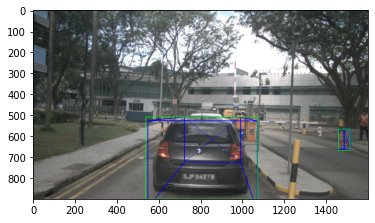

In [13]:
bboxes_json = []
for i in range(len(bbox_2d)):
    if bbox_3d_state_3d[i][3] <=0 or bbox_3d_state_3d[i][4] <=0 or bbox_3d_state_3d[i][5] <= 0:
        print(bbox_3d_state_3d[i])
        continue


    bboxes_json.append({
        'sample_token': '1',
        'bbox_2d': bbox_2d[i],
        'translation': (bbox_3d_state_3d[i][0], bbox_3d_state_3d[i][1] + 0.5*bbox_3d_state_3d[i][4], bbox_3d_state_3d[i][2]),
        'size': (bbox_3d_state_3d[i][4], bbox_3d_state_3d[i][3], bbox_3d_state_3d[i][5]),
#         'rotation': bbox_3d_state_3d[i][6],
        'rotation': thetas[i],
        'alpha': bbox_3d_state_3d[i][6],
        'velocity': 0.,
        # 'ego_translation': (0., 0., 0.),
        'num_pts': -1,
        'detection_name': obj_names[i],
        'detection_score': scores[i],
        'attribute_name': ''
    })

img_clone = np.copy(image)
render_image(3, bboxes_json, img_clone, p2)

In [ ]:
for score, box_3d, name in zip(scores, bboxes_json, obj_names):
    if score >= 0.7:
        print(name)
        print(box_3d)

In [ ]:
detector